In [1]:
import nltk
import pandas as pd
import pickle
import spacy
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from tensorflow import keras

2023-04-18 20:17:00.158495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 20:17:01.300387: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64
2023-04-18 20:17:01.300512: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/lib64
2023-04-18 20:17:01.300521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] 

In [8]:
import pandas as pd
df = pd.read_json("newsdataset.json", lines=True)

In [ ]:
model = spacy.load("en_core_web_trf")
df.head(5)

In [ ]:
df.drop(columns=["authors","link","date"], inplace=True)

In [ ]:
df.shape

In [ ]:
df.columns

In [ ]:
df["fullnews"] = df["headline"] +" "+ df["short_description"]

In [ ]:
df = df[["category","fullnews"]]

In [ ]:
df.sample(5)

In [ ]:
'''dropcat = ["RELIGION", "LATINO VOICES", "FIFTY", "WEIRD NEWS", "ENVIRONMENT", "QUEER VOICES", "GOOD NEWS", "MEDIA", "WEDDINGS", "GREEN", "TASTE", "WORLD NEWS", "IMPACT", "WOMEN"]

for i in dropcat:
    df.drop(df.loc[df["category"]==i].index, inplace=True, axis=0)

df.loc[df["category"]=="COLLEGE"] = ["EDUCATION"]
df.loc[df["category"]=="ARTS & CULTURE"] = ["CULTURE & ARTS"]
df.loc[df["category"]=="ARTS"] = ["CULTURE & ARTS"]
df.loc[(df["category"]=="SCIENCE") | (df["category"]=="TECH")] = ["SCIENCE & TECH"]
df.loc[df["category"]=="WORLDPOST"] = ["THE WORLDPOST"]
df.loc[df["category"]=="STYLE"] = ["STYLE & BEAUTY"]
df.loc[df["category"]=="MONEY"] = ["BUSINESS"]

df.reset_index(inplace=True, drop=True)
df.to_json("smalldataset/newsdataset.json", lines=True, orient="records")'''

In [ ]:
not_allowed_word_types = ["PUNCT", "DET", "PART", "CCONJ", "SPACE"]
token_news = []
count = 0

for i in df["fullnews"]:
    tokenised = model(i)
    smalltoken = [j.lemma_ for j in 
                  tokenised if j.pos_ not in not_allowed_word_types]
    token_news.append(smalltoken)
    count += 1
    if count%5000==0:
        print(count)

In [ ]:
df["tokenizednews"] = token_news

In [36]:
stop_words = stopwords.words("english")

In [37]:
all_words = [w.lower()
            for p in df["tokenizednews"]
            for w in p
            if w.lower() not in stop_words]

In [ ]:
"""allowed_word_types = ["J"]


for p in df["tokenizednews"]:
    pos = nltk.pos_tag(p)
    for w in pos:
        if w[1][0] in allowed_word_types:
            all_words.append(w[0].lower())"""

In [ ]:
"""print(len(all_words))
all_words = nltk.FreqDist(all_words)
print(len(all_words))"""

In [38]:
print(len(all_words))
all_wordsfre = nltk.FreqDist(all_words)
print(len(all_wordsfre))

2918465
69704


In [ ]:
all_wordsfre.most_common(15)

In [39]:
word_features = [w[0] for w in all_wordsfre.most_common()]

In [ ]:
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    
    return features

In [ ]:
df.shape[0]

In [ ]:
'''df.to_json("smalldataset/newsdatasetjson", lines=True, orient="records")'''

In [ ]:
file = open("smalldataset/word_features.pickle","wb")
pickle.dump(word_features, file)

In [ ]:
file = open("smalldataset/word_features.pickle", "rb")
word_features = pickle.load(file)
word_features = word_features[:10000]

In [ ]:
countvector = CountVectorizer().fit(word_features)
not_words = [i for i in word_features if i not in countvector.vocabulary_]

for i in not_words:
    word_features.remove(i)

word_features = word_features[:8000]
countvector = CountVectorizer().fit(word_features)

In [ ]:
encoder = OneHotEncoder()
encoder.fit(np.array(df["category"]).reshape(-1,1))

In [ ]:
df = pd.read_json("smalldataset/newsdataset.json", lines=True, chunksize=5000)

In [ ]:
def find_features(document):
    features = countvector.transform(document).toarray()
            
    return features

In [ ]:

def get_features():
    for data in df:

        Y = encoder.transform(np.array(data["category"]).reshape(-1,1)).toarray()

        X = find_features(data["fullnews"])

        break
        
    return X, Y
        

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import relu

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [4]:
from keras.layers import Bidirectional, Embedding, Conv1D, MaxPooling1D, SimpleRNN, LSTM, GRU, Dropout, Dense, Input

In [5]:
#checkpoint = keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
model = keras.Sequential([
    keras.layers.Input(shape=(8000,)),
    keras.layers.Dense(1000, activation="LeakyReLU"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(800, activation="LeakyReLU"),
    keras.layers.Dense(400, activation="LeakyReLU"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(200, activation="LeakyReLU"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation="softmax"),
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


2023-04-17 18:40:04.667416: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 18:40:04.669165: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 18:40:04.669470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 18:40:04.669625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [ ]:
model2 = keras.Sequential()
model2.add(Input(shape=8000))
model2.add(Embedding(8000, 3))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(20, activation='softmax'))
model2.summary()



model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [6]:
labencoder = LabelEncoder()
#encoder.classes_ = np.load("labelencoder15.npy", allow_pickle=True)

In [7]:
labencoder.fit(df["category"])
#np.save("smalldataset/labelencoder.npy", labencoder.classes_)

LabelEncoder()

In [ ]:
len(encoder.classes_)

In [ ]:
X_test = []
Y_test = []
checkpoint = keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)

In [ ]:
for i in range(10):
    X, Y = get_features()
    
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
    X_test.append(x_test)
    Y_test.append(y_test)
    print(X.shape, Y.shape)
    
    
    model2.fit(x_train, y_train, validation_split=0.2, epochs=5, batch_size=5, callbacks=checkpoint)
    print(f"Accuracy after {i} traindata")
    model2.evaluate(x_test,y_test)
    #model = keras.models.load_model("model.h5")
    

In [ ]:
model = keras.models.load_model("model.h5")

In [ ]:
X, Y = get_features()

In [ ]:
Y_pred = model.predict(X)

In [ ]:
y_pred_arg = np.argmax(Y_pred, axis = 1)

In [ ]:
max(Y_pred[0])

In [ ]:
labencoder.classes_[y_pred_arg[:5]]

In [ ]:
Y[:5]

In [ ]:
encoder.categories_

In [ ]:
labencoder.classes_

In [ ]:
kk = np.array(X_test)

In [ ]:
kk.shape

In [ ]:
kk = kk.reshape(-1, 8000)

In [ ]:
yy = np.array(Y_test)

In [ ]:
yy = yy.reshape(-1, 20)

In [ ]:
model.evaluate(kk, yy, batch_size=5)

In [ ]:
model.summary()

In [ ]:
model.summary()

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU, Input
from keras.models import Sequential
from keras.regularizers import L1L2
#from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_json("newsdataset.json", lines=True)
df["category"].value_counts()

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
STYLE & BEAUTY    11903
TRAVEL             9887
PARENTING          8677
BUSINESS           7644
HEALTHY LIVING     6694
THE WORLDPOST      6243
FOOD & DRINK       6226
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
SCIENCE & TECH     4260
HOME & LIVING      4195
PARENTS            3955
CULTURE & ARTS     3878
DIVORCE            3426
CRIME              3405
EDUCATION          2148
Name: category, dtype: int64

In [ ]:
stop_words = stopwords.words("english")

In [ ]:
all_words = [w.lower()
            for p in df["tokenizednews"]
            for w in p
            if w.lower() not in stop_words]

In [ ]:
print(len(all_words))
all_wordsfre = nltk.FreqDist(all_words)
print(len(all_wordsfre))

2918465
69704


In [ ]:
word_features = [w[0] for w in all_wordsfre.most_common()]
countvector = CountVectorizer(stop_words=stop_words).fit(word_features)

In [ ]:
vocab = list(countvector.vocabulary_.keys())

In [ ]:
numwords = len(vocab)

In [ ]:
X = df["reducedtoken"]
tokenizer = Tokenizer(num_words=numwords, oov_token='<00V>') 
tokenizer.fit_on_texts(X)
train_seq = tokenizer.texts_to_sequences(X)

In [71]:
templist = []
for i in df["tokenizednews"]:
    j = [k for k in i if k in vocab]
    templist.append(j)

In [ ]:
train_padseq = pad_sequences(train_seq, maxlen=136)

In [ ]:
encoder = OneHotEncoder()
encoder.fit(np.array(df["category"]).reshape(-1,1))

OneHotEncoder()

In [ ]:
Y = encoder.transform(np.array(df["category"]).reshape(-1,1)).toarray()

In [9]:
X = df["reducedtoken"]
train_seq = tokenizer.texts_to_sequences(X)
train_padseq = pad_sequences(train_seq, maxlen=136)

In [10]:
Y = encoder.transform(np.array(df["category"]).reshape(-1,1)).toarray()

In [30]:
#checkpoint = keras.callbacks.ModelCheckpoint("model5.h5", save_best_only=True)
model = keras.Sequential([
    keras.layers.Input(shape=136),
    keras.layers.Embedding(8000, 180),
    keras.layers.Flatten(),
    keras.layers.Dense(1200, activation="LeakyReLU"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(800, activation="LeakyReLU"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(500, activation="LeakyReLU"),
    keras.layers.Dense(300, activation="LeakyReLU"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(200, activation="LeakyReLU"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 136, 180)          1440000   
                                                                 
 flatten (Flatten)           (None, 24480)             0         
                                                                 
 dense (Dense)               (None, 1200)              29377200  


2023-04-06 23:19:20.245220: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 23:19:20.334974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 23:19:20.335276: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-06 23:19:20.336359: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

                                                                 
 dropout (Dropout)           (None, 1200)              0         
                                                                 
 dense_1 (Dense)             (None, 800)               960800    
                                                                 
 batch_normalization (BatchN  (None, 800)              3200      
 ormalization)                                                   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 300)               150300    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               60200     
          

In [11]:
padseq_train, padseq_test, y_train, y_test = train_test_split(train_padseq, Y, test_size=0.2)

In [27]:
model.fit(padseq_train, y_train, epochs=5, validation_split=0.2, callbacks=checkpoint, batch_size=20)

Epoch 1/5
5240/5240 [==============================] - 267s 51ms/step - loss: 0.6917 - accuracy: 0.7914 - val_loss: 1.7026 - val_accuracy: 0.6057
Epoch 2/5
5240/5240 [==============================] - 275s 52ms/step - loss: 0.5943 - accuracy: 0.8187 - val_loss: 4.8275 - val_accuracy: 0.4074
Epoch 3/5
5240/5240 [==============================] - 273s 52ms/step - loss: 0.5096 - accuracy: 0.8424 - val_loss: 2.3851 - val_accuracy: 0.5710
Epoch 4/5
5240/5240 [==============================] - 281s 54ms/step - loss: 0.4341 - accuracy: 0.8636 - val_loss: 1.9123 - val_accuracy: 0.6089
Epoch 5/5
5240/5240 [==============================] - 277s 53ms/step - loss: 0.3720 - accuracy: 0.8827 - val_loss: 2.1302 - val_accuracy: 0.5967


In [ ]:
model.fit(padseq_train, y_train, epochs=5, validation_split=0.2, batch_size=30)

Epoch 1/5
3494/3494 [==============================] - 208s 59ms/step - loss: 0.3616 - accuracy: 0.8858 - val_loss: 2.4018 - val_accuracy: 0.5394
Epoch 2/5
3494/3494 [==============================] - 211s 60ms/step - loss: 0.2782 - accuracy: 0.9113 - val_loss: 2.4440 - val_accuracy: 0.5352
Epoch 3/5
3494/3494 [==============================] - 213s 61ms/step - loss: 0.2318 - accuracy: 0.9254 - val_loss: 2.8670 - val_accuracy: 0.5286
Epoch 4/5
3494/3494 [==============================] - 216s 62ms/step - loss: 0.1926 - accuracy: 0.9375 - val_loss: 3.1081 - val_accuracy: 0.5330
Epoch 5/5
2035/3494 [================>.............] - ETA: 1:26 - loss: 0.1602 - accuracy: 0.9488

In [43]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 136, 180)          1440000   
                                                                 
 gru_1 (GRU)                 (None, 400)               698400    
                                                                 
 flatten_4 (Flatten)         (None, 400)               0         
                                                                 
 dropout_6 (Dropout)         (None, 400)               0         
                                                                 
 dense_17 (Dense)            (None, 800)               320800    
                                                                 
 batch_normalization_6 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                      

In [42]:
model = keras.models.load_model("model2.h5")

In [34]:
model.evaluate(padseq_test, y_test)

1024/1024 [==============================] - 3s 3ms/step - loss: 1.9992 - accuracy: 0.5975


[1.9991627931594849, 0.5975390076637268]

In [23]:
padseq_train[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   38, 1216,   97,
       1308, 2049,   97, 2049, 1216,   97,   10,  218,   18,  228,   20,
        462,   40, 8487, 1906], dtype=int32)

In [21]:
k2 = mod.predict(train_padseq[1])

5/5 [==============================] - 0s 935us/step


In [20]:
k.flatten()

array([ 0.03533294,  0.00897727, -0.02590462, ...,  0.01746919,
       -0.03165217,  0.02695059], dtype=float32)

In [22]:
k2.flatten()

array([ 0.03533294,  0.00897727, -0.02590462, ..., -0.04599941,
        0.02142418,  0.02448538], dtype=float32)

In [24]:
min([len(i) for i in train_seq])

0

In [4]:
model.build()

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1000)              8001000   
                                                                 
 dropout (Dropout)           (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 800)               800800    
                                                                 
 dense_2 (Dense)             (None, 400)               320400    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 200)               80200     
                                                                 
 batch_normalization (BatchN  (None, 200)              8

In [6]:
import pickle
with open("tokenizer.pickle", "rb") as file: 
    tokenizer= pickle.load(file)
    
with open("labelencoder.pickle", "rb") as file:
    labelencoder = pickle.load(file)

In [7]:
with open("onehotencoder.pickle", "rb") as file: 
    encoder = pickle.load(file)

In [9]:
encoder

OneHotEncoder()

In [12]:
#checkpoint = keras.callbacks.ModelCheckpoint("model5.h5", save_best_only=True)
model = keras.Sequential([
    keras.layers.Input(shape=136),
    keras.layers.Embedding(8000, 200),
    
    #keras.layers.Reshape(target_shape=(-1, 1)),
    keras.layers.Conv1D(128, 3),
    keras.layers.Flatten(),
    keras.layers.Dense(300, activation="LeakyReLU"),
    keras.layers.Dense(200, activation="LeakyReLU"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(20, activation="softmax")
])
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 136, 200)          1600000   
                                                                 
 conv1d_5 (Conv1D)           (None, 134, 128)          76928     
                                                                 
 flatten_7 (Flatten)         (None, 17152)             0         
                                                                 
 dense_21 (Dense)            (None, 300)               5145900   
                                                                 
 dense_22 (Dense)            (None, 200)               60200     
                                                                 
 batch_normalization_7 (Batc  (None, 200)              800       
 hNormalization)                                                 
                                                      

In [11]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
model.fit(padseq_train, y_train, epochs=5, validation_split=0.2, callbacks=[tensorboard_callback], batch_size=100)

NameError: name 'model' is not defined

In [19]:
import torch

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
device

device(type='cuda', index=0)

In [30]:
ta = torch.tensor(np.ones((2,2)), dtype=float).cuda()

In [31]:
ta

tensor([[1., 1.],
        [1., 1.]], device='cuda:0', dtype=torch.float64)

In [15]:
convlayers = [0, 1, 2]
numfilters = [64, 128, 256]
denselayers = [1, 2, 3]
densesizes = [256, 512]

In [23]:
for convlayer in convlayers:
    for numfilter in numfilters:
        for denselayer in denselayers:
            for densesize in densesizes:
                log_dir = f"logs/{convlayer}-conv{numfilter}-{denselayer}-dense{densesize}-{int(time.time())}"
                model = keras.Sequential()
                model.add(keras.layers.Input(shape=136))
                model.add(keras.layers.Embedding(8000, 200))
                
                for i in range(convlayer):
                    model.add(keras.layers.Conv1D(numfilter, 3, activation="relu"))
                
                model.add(keras.layers.Flatten())
                
                for i in range(denselayer):
                    model.add(keras.layers.Dense(densesize, activation="LeakyReLU"))
                    if i%2==0:
                        model.add(keras.layers.ActivityRegularization(l2=0.01))
                        
                model.add(keras.layers.BatchNormalization())
                model.add(keras.layers.Dense(20, activation="softmax"))
                model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
                
                tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
                
                model.fit(padseq_train, y_train, epochs=5, validation_split=0.2, callbacks=[tensorboard_callback], batch_size=200)

                

In [21]:
for convlayer in convlayers:
    for numfilter in numfilters:
        for denselayer in denselayers:
            for densesize in densesizes:
                log_dir = f"logs/{convlayer}-conv{numfilter}-{denselayer}-dense{densesize}-{int(time.time())}"
                print(log_dir)

logs/0-conv64-1-dense256-1680593236
logs/0-conv64-1-dense512-1680593236
logs/0-conv64-2-dense256-1680593236
logs/0-conv64-2-dense512-1680593236
logs/0-conv64-3-dense256-1680593236
logs/0-conv64-3-dense512-1680593236
logs/0-conv128-1-dense256-1680593236
logs/0-conv128-1-dense512-1680593236
logs/0-conv128-2-dense256-1680593236
logs/0-conv128-2-dense512-1680593236
logs/0-conv128-3-dense256-1680593236
logs/0-conv128-3-dense512-1680593236
logs/0-conv256-1-dense256-1680593236
logs/0-conv256-1-dense512-1680593236
logs/0-conv256-2-dense256-1680593236
logs/0-conv256-2-dense512-1680593236
logs/0-conv256-3-dense256-1680593236
logs/0-conv256-3-dense512-1680593236
logs/1-conv64-1-dense256-1680593236
logs/1-conv64-1-dense512-1680593236
logs/1-conv64-2-dense256-1680593236
logs/1-conv64-2-dense512-1680593236
logs/1-conv64-3-dense256-1680593236
logs/1-conv64-3-dense512-1680593236
logs/1-conv128-1-dense256-1680593236
logs/1-conv128-1-dense512-1680593236
logs/1-conv128-2-dense256-1680593236
logs/1-conv12

In [17]:
import time

In [4]:
df2 = pd.DataFrame(df["category"].value_counts())

In [13]:
df2.sort_values(by="index", inplace=True)

In [19]:
df2.drop(columns="level_0", inplace=True)

In [21]:
total = df.shape[0]
total

163752

In [23]:
lst = [(1/i)*(total/20) for i in df2["category"]]

In [24]:
df2["coeff"] = lst
df2

,index,category,coeff
0,BLACK VOICES,4528,1.808216
1,BUSINESS,7644,1.071115
2,COMEDY,5175,1.582145
3,CRIME,3405,2.404581
4,CULTURE & ARTS,3878,2.111294
5,DIVORCE,3426,2.389842
6,EDUCATION,2148,3.811732
7,ENTERTAINMENT,16058,0.509877
8,FOOD & DRINK,6226,1.315066
9,HEALTHY LIVING,6694,1.223125


In [27]:
weight_class = {}
count = 0
for i in df2["coeff"]:
    weight_class[count] = i
    count+=1

In [28]:
weight_class

{0: 1.8082155477031803,
 1: 1.0711145996860283,
 2: 1.5821449275362318,
 3: 2.404581497797357,
 4: 2.1112944816915937,
 5: 2.3898423817863397,
 6: 3.8117318435754193,
 7: 0.5098766969734712,
 8: 1.3150658528750403,
 9: 1.223125186734389,
 10: 1.9517520858164483,
 11: 0.9435980177480697,
 12: 2.070189633375474,
 13: 0.25008705213964993,
 14: 1.9219718309859155,
 15: 1.6764127764127765,
 16: 0.6878602033100899,
 17: 1.3114848630466123,
 18: 0.8281177303529889,
 19: 0.45928086610198016}

In [33]:
encoder.categories_

[array(['BLACK VOICES', 'BUSINESS', 'COMEDY', 'CRIME', 'CULTURE & ARTS',
        'DIVORCE', 'EDUCATION', 'ENTERTAINMENT', 'FOOD & DRINK',
        'HEALTHY LIVING', 'HOME & LIVING', 'PARENTING', 'PARENTS',
        'POLITICS', 'SCIENCE & TECH', 'SPORTS', 'STYLE & BEAUTY',
        'THE WORLDPOST', 'TRAVEL', 'WELLNESS'], dtype=object)]

In [5]:
model = keras.models.load_model("3-conv128-3-dense256-1680808526-weighted.h5")

2023-04-17 22:35:24.391341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 22:35:24.392419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 22:35:24.392862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-17 22:35:24.393168: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 136, 200)          1600000   
                                                                 
 conv1d (Conv1D)             (None, 134, 128)          76928     
                                                                 
 conv1d_1 (Conv1D)           (None, 132, 128)          49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 130, 128)          49280     
                                                                 
 flatten (Flatten)           (None, 16640)             0         
                                                                 
 dense (Dense)               (None, 256)               4260096   
                                                                 
 activity_regularization (Ac  (None, 256)              0

In [5]:
model = keras.models.load_model("3-conv128-3-dense256-1680808526-weighted.h5")
model.summary()

2023-04-18 20:28:08.661764: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 20:28:08.662703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 20:28:08.663055: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-18 20:28:08.663234: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 136, 200)          1600000   
                                                                 
 conv1d (Conv1D)             (None, 134, 128)          76928     
                                                                 
 conv1d_1 (Conv1D)           (None, 132, 128)          49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 130, 128)          49280     
                                                                 
 flatten (Flatten)           (None, 16640)             0         
                                                                 
 dense (Dense)               (None, 256)               4260096   
                                                                 
 activity_regularization (Ac  (None, 256)              0

In [32]:
model.evaluate(padseq_test, y_test, batch_size=1)

32751/32751 [==============================] - 71s 2ms/step - loss: 1.0451 - accuracy: 0.7112


[1.0451329946517944, 0.7112149000167847]

In [13]:
from sklearn.metrics import confusion_matrix

In [15]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
ans = np.argmax(y_pred, axis = 1)
#ans = labelencoder.classes_[ans]

In [21]:
y_testnum = np.argmax(y_test, axis=1)

In [23]:
conf = confusion_matrix(y_testnum, ans)

In [24]:
import seaborn as sns

In [29]:
conf

array([[ 579,    6,   18,   41,   44,    3,   20,   36,    5,    6,    1,
           9,    7,   84,    2,   22,   16,    5,    4,    5],
       [   9,  960,   26,    9,   20,    3,   66,    6,   18,   26,   12,
          15,    6,   80,   77,   17,   12,   31,   24,   90],
       [   9,   11,  666,    6,   31,    2,   12,   77,   12,   10,    6,
          11,    9,   65,   20,   39,    4,    8,    9,   16],
       [  11,   11,    2,  522,    1,    1,    6,    3,    1,    0,    1,
           3,    2,   52,    5,   10,    2,   25,    3,    1],
       [  19,    2,   17,    2,  622,    2,   10,   21,    3,    5,    8,
           7,    2,   10,   13,    9,   13,    6,   18,    8],
       [   1,    1,    5,    1,    2,  640,    2,    7,    2,    3,    0,
          12,    8,    5,    2,    4,    3,    1,    3,    4],
       [  11,    9,    5,    3,    6,    0,  361,    2,    0,    1,    1,
          11,    3,   21,    3,    0,    0,    2,    1,    9],
       [ 215,   13,  234,   36,  353,   2

<AxesSubplot: >

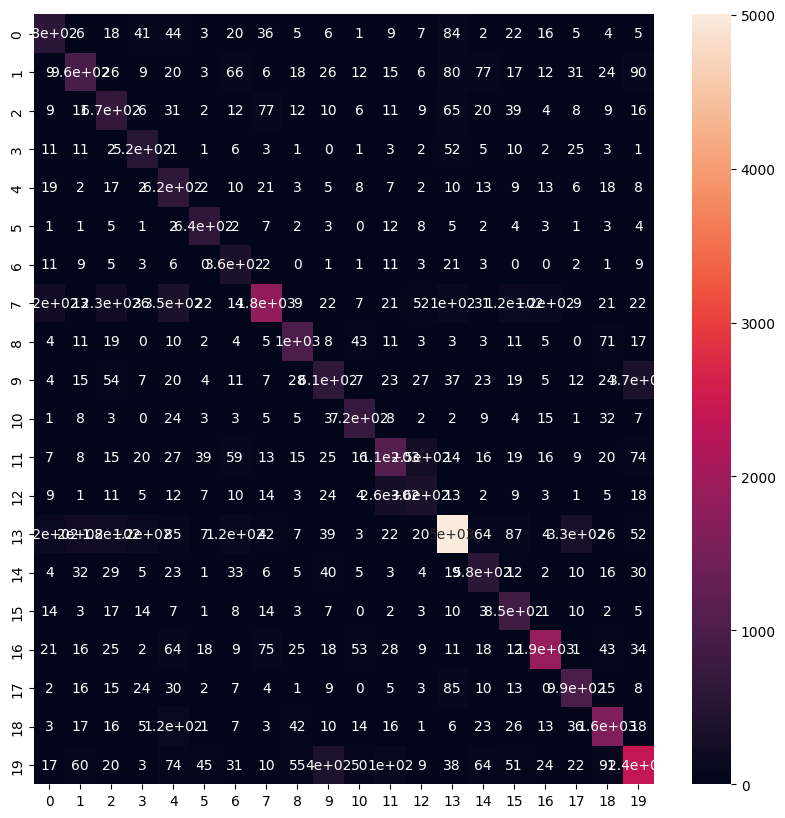

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
sns.heatmap(conf, annot=True)